In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.read_ipcc_bib import read_bib_wg
from code_utils.enriching_data_OpenAlex import get_countries_concepts_sdg,get_publi_not_in_ipcc,get_open_alex_data
from code_utils.utils import aplatir,wg_chap_to_dict,get_doi_cleaned
from code_utils.glutton import get_doi_glutton
from code_utils.pickle import load_cache,write_cache

In [27]:
cached_openalex_data = {}

In [28]:
try:
    cached_openalex_data = load_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')
except:
    write_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')

53358 data in cached openalex data


Read IPCC references in .bib files

In [ ]:
wgs={'1':{'wg1':[], 'dataframes_1':{}, 'listdir1':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG1")},
     '2':{'wg2':[], 'wg2_update':[], 'dataframes_2':{}, 'listdir2':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2")},
     '2_CROSS':{'wg2_CROSS':[], 'wg2_CROSS_update':[], 'dataframes_2_CROSS':{}, 'listdir2_CROSS':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG2_CROSS")},
     '3':{'wg1':[], 'dataframes_3':{}, 'listdir3':os.listdir(module_path+f"\\IPCC_bibliography\\AR6\\WG3")}}

In [ ]:
for k in ['1','2','2_CROSS','3']:
    wgs[k][f'df_{k}'] = read_bib_wg(wgs,k,verbose=True)
    print(wgs[k][f'wg{k}_update'])
    #wgs[k][f'df_{k}'].to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', orient='records', lines=True)

Read and clean the data from 'structured_data' folder

In [6]:
data_all={}

In [7]:
for k in ['1','2','2_CROSS','3']:
   data_all[f'df_wg{k}']=pd.read_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_wg{k}.jsonl', lines= True)

In [8]:
#all data 
df_ipcc=pd.concat(list(data_all.values()), ignore_index=True)

In [9]:
df_ipcc.loc[:,'doi']=df_ipcc.loc[:,'doi'].apply(lambda x: get_doi_cleaned(x))
df_ipcc.loc[:,'doi']=df_ipcc.loc[:,'doi'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_ipcc['freq']=1

Enriching data through OpenAlex API integration

In [10]:
df_unique_doi=df_ipcc.groupby(by=['year','doi','title','author'], dropna=True).agg({'wg': lambda x: list(x),'chap': lambda x: list(x), 'freq': 'sum'})

In [11]:
df_unique_doi=df_unique_doi.reset_index()

In [12]:
#get data_OpenAlex from the API (6h)
df_unique_doi.apply(lambda row: get_open_alex_data(cached_openalex_data,row['doi']), axis= 1)
write_cache(cached_openalex_data,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data.pkl')

In [13]:
countries_list = []
concepts_list = []
sdg_list = []
for i,row in df_unique_doi.iterrows():
    countries,concepts,sdg,year=get_countries_concepts_sdg(cached_openalex_data,row)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    

df_unique_doi['countries'] = countries_list
df_unique_doi['concepts'] = concepts_list
df_unique_doi['sdg'] = sdg_list

In [14]:
df_unique_doi['wg_chap']=df_unique_doi.apply(lambda row: wg_chap_to_dict(row), axis=1)

Visualization of the contribution of each countries in ipcc references

In [15]:
df_unique_doi=df_unique_doi[['doi','countries','concepts','sdg','wg_chap']]

In [16]:
df_ipcc=pd.merge(df_ipcc, df_unique_doi, on='doi', how='left')
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipcc.loc[:,'countries']=df_ipcc.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [17]:
data_counts = pd.Series(aplatir(list(df_ipcc['countries']))).value_counts().drop('None')

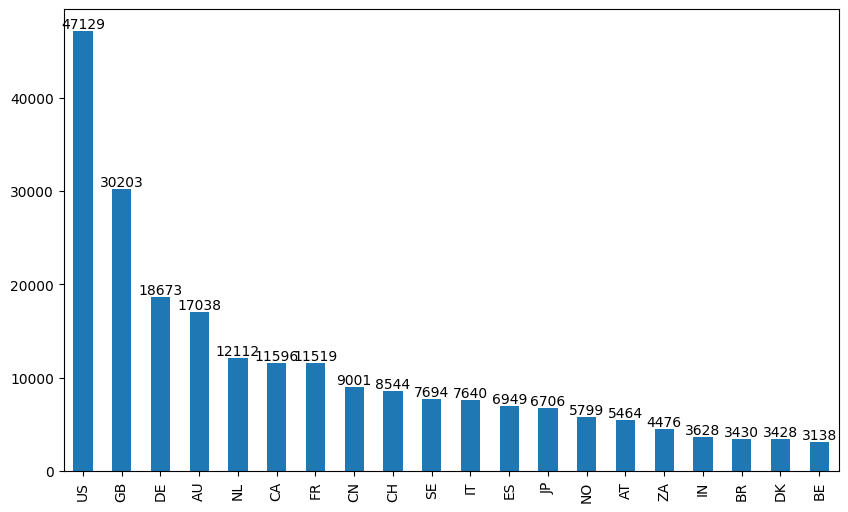

In [18]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Find the data for constructing the learning model ( IPCC related or not )

In [19]:
df_ipcc[df_ipcc['wg']=='wg1'].year.max()

2021

In [20]:
df_ipcc['year'] = pd.to_numeric(df_ipcc['year'], errors='coerce')
year=df_ipcc.drop_duplicates(subset='doi')['year'].dropna().sort_values().apply(lambda x: int(x))
year_counts = pd.Series(list(year)).value_counts().to_dict()
del year_counts[202]

In [21]:
dois=list(df_unique_doi.doi)

In [22]:
dict_year={}
year_counts_not_ipcc={}

In [31]:
while sum(list(year_counts_not_ipcc.values()))<(len(dois)):
    print(sum(list(year_counts_not_ipcc.values())))
    get_publi_not_in_ipcc(dois,dict_year,year_counts,year_counts_not_ipcc)

59
59
59
59
59
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
60
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
61
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
62
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
63
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
65
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
71
72
72
72
72
72
72
7

In [ ]:
pd.DataFrame(aplatir(list(dict_year.values()))).to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipcc.jsonl', orient= 'records', lines= True)